# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [2]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

 1. Is the distribution of body temperatures normal? 
 2. Is the sample size large? Are the observations independent?
     - There are 130 observations in the data. 

In [3]:
print(df.shape)

(130, 3)


## Ploting the empirical cumulative distribution of the temperature and simulated data from normal distritbution

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.style.use('ggplot')
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x,y

In [5]:
smean = np.mean(df.temperature)
sstd = np.std(df.temperature)
simdata = np.random.normal(smean, sstd, size=10000)

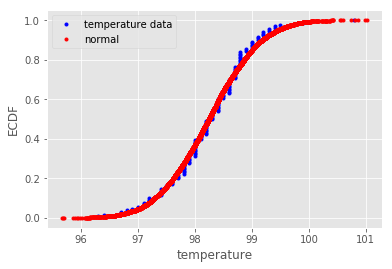

In [6]:
xsim, ysim = ecdf(simdata)
x, y = ecdf(df.temperature)
plt.plot(x, y, marker='.', linestyle='none', color='blue')
plt.plot(xsim, ysim, marker='.', linestyle='none', color='red')
plt.xlabel('temperature')
plt.ylabel('ECDF')

plt.legend(('temperature data', 'normal'));

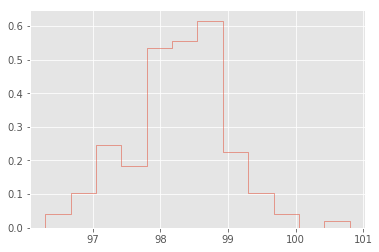

In [7]:
plt.hist(df.temperature, density=True, bins=12, histtype='step');

Three normality statistical tests:
1. Shapiro 
2. $\chi^2$ test
3. Anderson or KStest


- Skew is a quantification of how much a distribution is pushed left or right, a measure of asymmetry in the distribution.
- Kurtosis quantifies how much of the distribution is in the tail. It is a simple and commonly used statistical test for normality.

In [8]:
from scipy.stats import shapiro,normaltest, anderson
stat, p = shapiro(df.temperature)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=0.987, p=0.233


In [9]:
stat, p = normaltest(df.temperature)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=2.704, p=0.259


In [10]:
result = anderson(df.temperature)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 0.520
15.000: 0.560, data looks normal (fail to reject H0)
10.000: 0.637, data looks normal (fail to reject H0)
5.000: 0.765, data looks normal (fail to reject H0)
2.500: 0.892, data looks normal (fail to reject H0)
1.000: 1.061, data looks normal (fail to reject H0)


All the statitical tests and plot show that the temperature data is normally distributed. The sample size is 130, which is larger than 30, we could apply central limit theory here.

<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>



In [15]:
print('The mean temperature of the sample is {:.3f}'.format(smean))

The mean temperature of the sample is 98.249


## bootstrap hypothesis test

In [16]:
def bs_replicates(data, func, size=1):
    bs_rep = np.empty(size)
    for i in range(size):
        bs_rep[i] = func(np.random.choice(data, size=len(data)))
    return bs_rep

In [17]:
mu = 98.6
np.random.seed(42)
smean = np.mean(df.temperature)
sample_shift = df.temperature - smean + mu
bs_mean = bs_replicates(sample_shift, np.mean, 10000)
p = np.sum(bs_mean<=smean)/len(bs_mean)
print('The p-value with bootstraping samples is {:.3f}'.format(p))

The p-value with bootstraping samples is 0.000


## frequentist statistical testing
I am using one-sample z-test here. As the sample size is 130, which is larger than 30, we can apply Central Limit Theorem. So the sample variance could be a good estimate of population variance. It turns out that the one-sample t-test and z-test yield the same results. The reason is that with large sample size and CLT, sample variance is a pretty accurate estimator of population variance. 

In [18]:
import scipy.stats as ss
smean = np.mean(df.temperature)
n = len(df.temperature)
pvalue = 2 * ss.norm.cdf((smean - mu)/(sstd/np.sqrt(n)))
print('The p-value with one-sample Z-test is {:.3f}'.format(pvalue))

The p-value with one-sample Z-test is 0.000


In [19]:
pvalue = 2 * ss.t.cdf((smean - mu)/(sstd/np.sqrt(n)), n-1)
print('The p-value with one-sample t-test is {:.3f}'.format(pvalue))

The p-value with one-sample t-test is 0.000


<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>

When the sample size is 10, we do not have CLT work anymore. So the t-test is more approriate here.

In [21]:
nsample = 10
sampletemp = df.temperature.sample(nsample)
smean = np.mean(sampletemp)
sstd = np.std(sampletemp)
print('The sample mean is {:.3f}'.format(smean), 'The true mean is {:.3f}'.format(mu))
if smean < mu:
    pvalue = 2 * ss.norm.cdf((smean - mu)/(sstd/np.sqrt(nsample)))
else:
    pvalue = 2 * (1 - ss.norm.cdf((smean - mu)/(sstd/np.sqrt(nsample))))
print('The p-value with one-sample Z-test is {:.3f}'.format(pvalue))

if smean < mu:
    pvalue = 2 * ss.t.cdf((smean - mu)/(sstd/np.sqrt(nsample)), nsample-1)
else:
    pvalue = 2 * (1 - ss.t.cdf((smean - mu)/(sstd/np.sqrt(nsample))), nsample-1)
print('The p-value with one-sample t-test is {:.3f}'.format(pvalue))

The sample mean is 98.280 The true mean is 98.600
The p-value with one-sample Z-test is 0.213
The p-value with one-sample t-test is 0.245


<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>

When the temperature is not in the following range, we consider it as "abnormal".

In [23]:
bs_mean = bs_replicates(df.temperature, np.mean, size=10000)
confidence_int = np.percentile(bs_mean, [2.5, 97.5])
margin_error = (confidence_int[1] - confidence_int[0])/2
print('The 95% confidence interval with bootstrap is [{:.3f}, {:.3f}]'.format(
    confidence_int[0],confidence_int[1]))
print('The margin of error is {:.3f}'.format(margin_error))

The 95% confidence interval with bootstrap is [98.124, 98.372]
The margin of error is 0.124


In [24]:
smean = np.mean(df.temperature)
sstd = np.std(df.temperature)
n = len(df.temperature)
margin_error = 1.96*sstd/np.sqrt(n)
confidence_int = [smean - margin_error, smean + margin_error]
print('The 95% confidence interval with frequentist test is [{:.3f}, {:.3f}]'.format(
    confidence_int[0],confidence_int[1]))
print('The margin of error is {:.3f}'.format(margin_error))

The 95% confidence interval with frequentist test is [98.124, 98.375]
The margin of error is 0.126


<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>

In [25]:
fem_temp = df.loc[df.gender=='F', 'temperature']
mal_temp = df.loc[df.gender=='M', 'temperature']

## Permutation Test

In [29]:
def perm_replicates(d1, d2, func, size=1):
    d = np.concatenate((d1, d2))
    rep = np.empty(size)
    for i in range(size):
        data = np.random.permutation(d)
        d1perm = data[:len(d1)]
        d2perm = data[len(d1):]
        rep[i] = func(d1perm, d2perm)
    return rep

def mean_diff(d1, d2):
    return np.mean(d1) - np.mean(d2)

In [31]:
perm_mean = perm_replicates(fem_temp, mal_temp, mean_diff, size=10000)
obs = mean_diff(fem_temp, mal_temp)
np.sum(perm_mean>=obs)/len(perm_mean)

0.0129

## Bootstraping Sample

In [28]:
smean = np.mean(df.temperature)
fem_shift = fem_temp - np.mean(fem_temp) + smean
mal_shift = mal_temp - np.mean(mal_temp) + smean
fem_rep = bs_replicates(fem_shift, np.mean, size=10000)
mal_rep = bs_replicates(mal_shift, np.mean, size=10000)
mean_rep = fem_rep - mal_rep
np.sum(mean_rep>=obs)/10000

0.0122

## Two-sample T-test

In [114]:
from scipy.stats import ttest_ind
ttest_ind(fem_temp, mal_temp)

Ttest_indResult(statistic=2.2854345381656103, pvalue=0.02393188312239561)

## Conclusions
Overall, from the current dataset with 130 samples, we conclude that 
- The distribution of temperature is approximately nomal, confimed by frequentist test, including KStest, $\chi^2$ test, shipiro test, as well as ECDF with simulated normal data.
- We tested the null hypothesis that the true mean of the temperature data is 98.6. However, we have enough evidence to reject the null hypothesis at 5% siginificant level, using frequentist test and bootstraping samples.
- With large samples ( $> 30$), central limit theory applies and we could carry one-sample z-test for null hypothesis that $\mu = 98.6$; when sample size is small, we use t-test instead.
- I also compute confidence interval for the temperature mean, using both bootstraping sample and hypothesis. The results from both methods are in alignment with each other. The confidence interval shows that the true mean falls in the interval for 95% of the random sample. Again, since the confidence interval does not include 98.6, we have strong evidence to show the true mean is not 98.6, with 95% confidence.
- To test if the mean temperature is the same for male and female, I am testing the hypothesis that $\mu_{female} = \mu_{male}$. I used three methods here
    - Two sample t-test for independent samples
    - Permutation test when assuming the null hypothesis is true
    - Bootstrapping sample
    
  all three methods confirmed that we have strong evidence to reject the null hypothesis at 5% significant level.